# Notebook to reproduce Supplementary figure 1

In [1]:
import os
import sys
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

sys.path.append(os.path.join(sys.path[0], '../'))
from plot import plot_settings, plot_utils
from config import GEMINI_DIR

In [2]:
fig_dir = 'figure/supplementary_figure_1/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Compute network statistics

In [3]:
reload_existing_results = True  # note: much slower if we don't do this!!

In [4]:
def filt(spec, network_type, net):
    if network_type == 'Combo':
        return '_gm_adjacency.txt' in net
    is_string = any([net == '{}_string_{}_gm_adjacency.txt'.format(
        spec if spec != 'human' else 'human_match', evidence)
                for evidence in ['neighborhood', 'fusion', 'cooccurence', 
                                 'coexpression', 'experimental', 'database']])
    if network_type == 'String':
        return is_string
    # otherwise, must be biogrid
    assert network_type == 'BioGrid'
    return not is_string and '_gm_adjacency.txt' in net

In [5]:
if not reload_existing_results:
    degrees = {net: {spec: [] for spec in ['human', 'mouse', 'yeast']} for net in ['BIOGRID', 'STRING']}

    for spec in ['human', 'mouse', 'yeast']:
        print('...', spec)
        for net in ['String', 'BioGrid']:
            print('\t...', net)
            fdir = GEMINI_DIR + 'data/networks/'
            fdir += 'human_match' if spec.lower() == 'human' else spec.lower()

            names = os.listdir(fdir)
            net_names = ['{}/{}'.format(fdir, fname) for fname in names if filt(spec, net, fname)]

            for n in net_names:
                deg = {}  # node: degree
                df = pd.read_csv(n, names=['gene a', 'gene b', 'weight'], delimiter=' ')
                for ga in np.unique(df['gene a'].tolist()):
                    deg[ga] = len(df[df['gene a'] == ga]) + len(df[df['gene b'] == ga])
                degrees[net.upper()][spec.lower()].extend(list(deg.values()))
                
    max_degree = 0
    for n in degrees:
        for s in degrees[n]:
            max_degree = max(max_degree, max(degrees[n][s]))
            degrees[n][s] = np.asarray(degrees[n][s])

    cum_sum_degrees = {n: {s: [] for s in ['human', 'mouse', 'yeast']} for n in ['BIOGRID', 'STRING']}
    for n in degrees:
        for s in degrees[n]:
            cum_sum_degrees[n][s] = [len(degrees[n][s][degrees[n][s] >= d]) for d in range(max_degree)]
    
    if not os.path.exists('figure_results/'):
        os.makedirs('figure_results/')
    with open('figure_results/cumulative_node_degrees.txt', 'w') as f:
        json.dump(cum_sum_degrees, f)

In [6]:
if reload_existing_results:
    with open('figure_results/cumulative_node_degrees.txt', 'r') as f:
        cum_sum_degrees = json.load(f)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


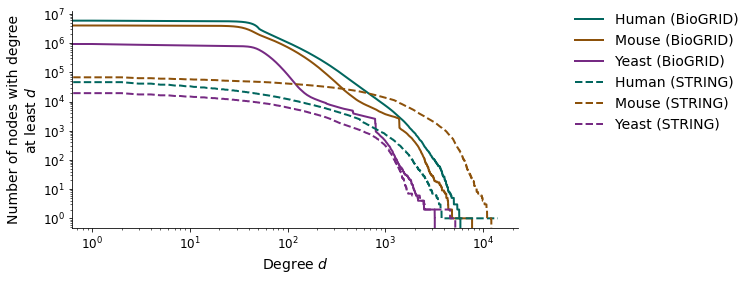

In [7]:
%matplotlib inline

ax = plot_settings.get_wider_axis(True)
for n in cum_sum_degrees:
    for s in cum_sum_degrees[n]:
        plot_utils.line_plot(
            ax, cum_sum_degrees[n][s], xlabel='Degree $d$', ylabel='Number of nodes with degree\nat least '+r'${d}$',
            label_marker='{} ({})'.format(
                s[0].upper()+s[1:].lower(), plot_settings.get_network_naming_convention(n)),
            yscale='log', xscale='log', color=plot_settings.get_species_color(s),
            linestyle=plot_settings.get_network_linestyle(n), linewidth=2)
plot_utils.format_legend(ax, *ax.get_legend_handles_labels())
plot_utils.put_legend_outside_plot(ax)
plot_utils.format_ax(ax)
plt.savefig(fig_dir + 'figure_S1.pdf', bbox_inches='tight')